# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold,cross_validate,GridSearchCV
import xgboost as xgb
from pathlib import Path
import os
import lightgbm as lgb
import json
import matplotlib.pyplot as plt
from flask import Flask, request, Response
import requests
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from boruta import BorutaPy
from IPython.display import Image
from IPython.display import display, HTML

# Functions

In [86]:
def jupyter_settings():

    %matplotlib inline
    %pylab inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))

    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

def calculate_metrics(nome_algoritmo, y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    df = pd.DataFrame({
        'Algorithm': [nome_algoritmo],
        'Precision': [precision],
        'Recall': [recall],
        'Accuracy': [accuracy]
    })

    return df

def cross_validation_kfold(model, X, y):
    num_folds = 10
    scores = ['precision', 'recall']
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    scores_results = cross_validate(model, X, y, scoring=scores, cv=kfold)
    model_name = model.__class__.__name__
    precision_mean = scores_results['test_precision'].mean()
    recall_mean = scores_results['test_recall'].mean()

    result_df = pd.DataFrame([{
        'model': model_name,
        'precision': precision_mean,
        'recall': recall_mean
    }])

    return result_df

def rescale(data, column_name):
    scaler = RobustScaler()
    data[[column_name]] = scaler.fit_transform(data[[column_name]])  
    pickle.dump(scaler, open(f'../parameter/{column_name}_scaler.pkl', 'wb'))  
    return data

columns_to_scale = ['lead_time', 'avg_price_per_room', 'average_ticket']

for col in columns_to_scale:
    df = rescale(df, col)

def encoding_label(data, column_name):
    encoder = LabelEncoder()
    data[column_name] = encoder.fit_transform(data[column_name])       
    pickle.dump(encoder, open(f'../parameter/{column_name}_encoder.pkl', 'wb'))  
    return data

encode_columns = ['room_type_reserved', 'type_of_meal_plan', 'market_segment_type', 'price_category']

for col in encode_columns:
    df = encoding_label(df, col)


# Data Load

In [6]:
df = pd.read_csv('../datasets/hotel.csv')
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


# Preprocessing

## Data types handling

In [7]:
df.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

In [8]:
binary_cols = ['repeated_guest', 'required_car_parking_space']
df[binary_cols] = df[binary_cols].astype(bool)

## Handling null values

In [9]:
df.isnull().sum()
# There are no null values for this dataset

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

# Feature engineering

## Hypothesis Mind map

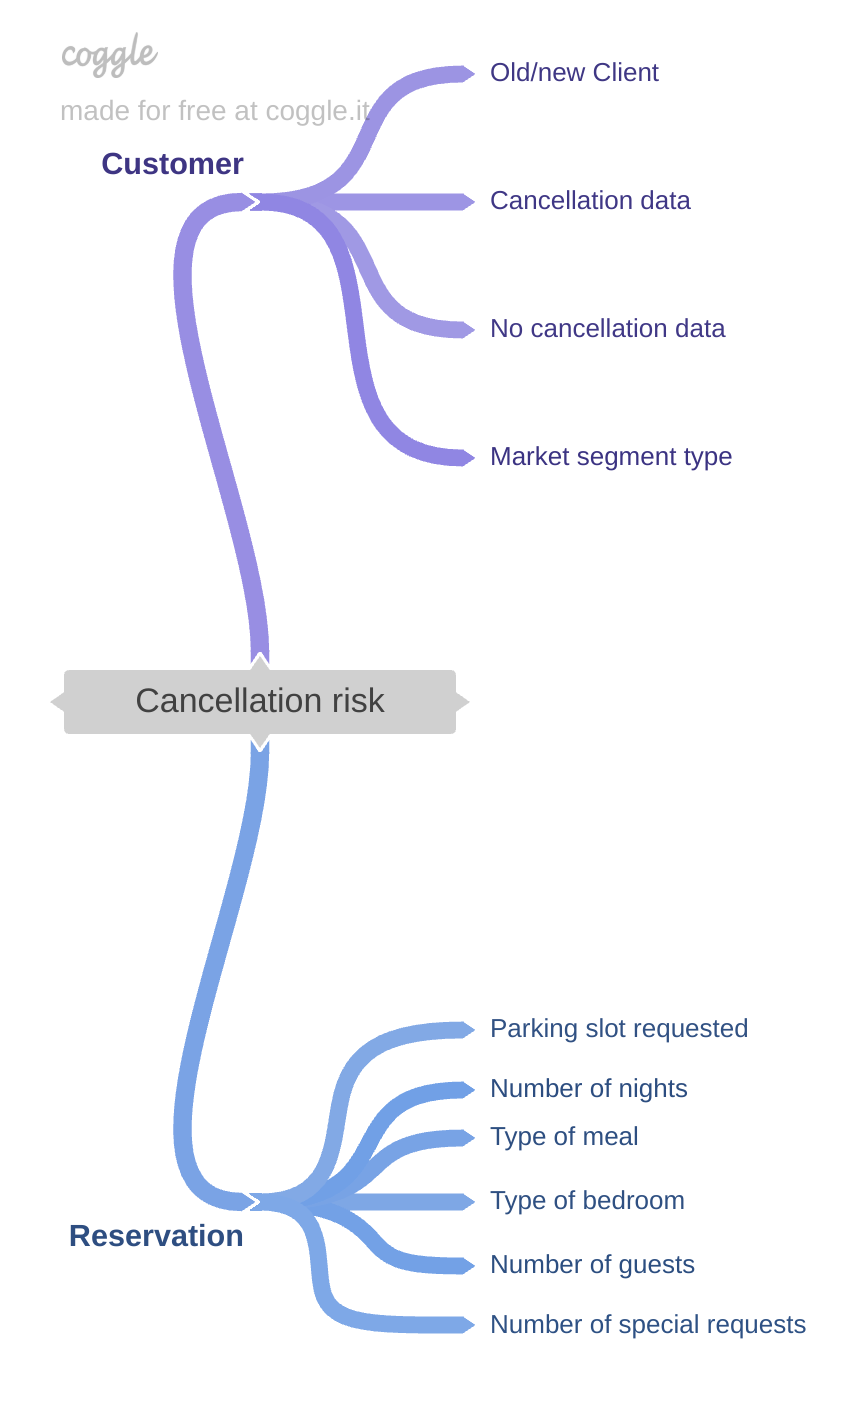

In [10]:
Image('../Hypothesis mind map.png')

## Client Hypothesis

- People that cancelled before may have a greater chance to cancel again
- Old clients tend to cancel less
- People that never cancelled tends to not cancel


## Reservation Hypothesis

- Greater lead time have a greater chance to cancel
- A higher number of people brings more possibility of cancellation
- A high number of special requests indicates greater chance of cancellation


## Creating new features

In [11]:
df['no_guests'] = df['no_of_children'] + df['no_of_adults']
df['no_days'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
df['average_ticket'] = df['avg_price_per_room']/df['no_guests']
df['is_family'] = ((df['no_of_children'] > 0) & (df['no_of_adults'] >= 2)).astype(bool)

df['booking_month'] = df['arrival_month'] - (df['lead_time'] // 30)
df['booking_month'] = df['booking_month'].apply(lambda x: x + 12 if x <= 0 else x)

df['price_category'] = pd.qcut(df['avg_price_per_room'], q=4, labels=['low', 'mid-low', 'mid-high', 'high'])



# Univariate analysis


## Target variable

<Axes: xlabel='count', ylabel='booking_status'>

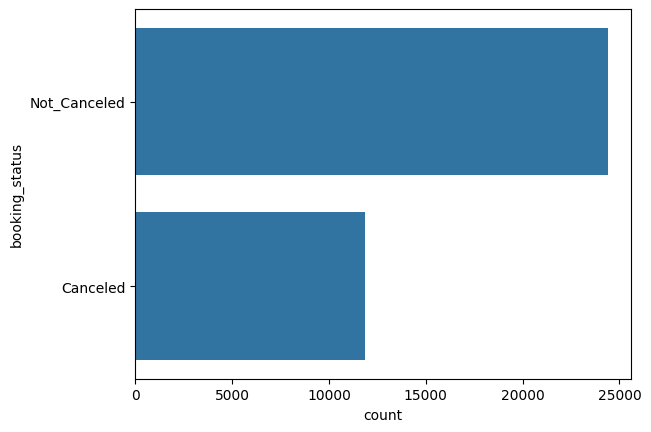

In [12]:
aux = df.copy()
aux['booking_status'] = aux['booking_status']

sns.countplot(aux['booking_status'])

## Numerical variables

In [13]:
num_variables = aux.select_dtypes(include=['int64','float64'])

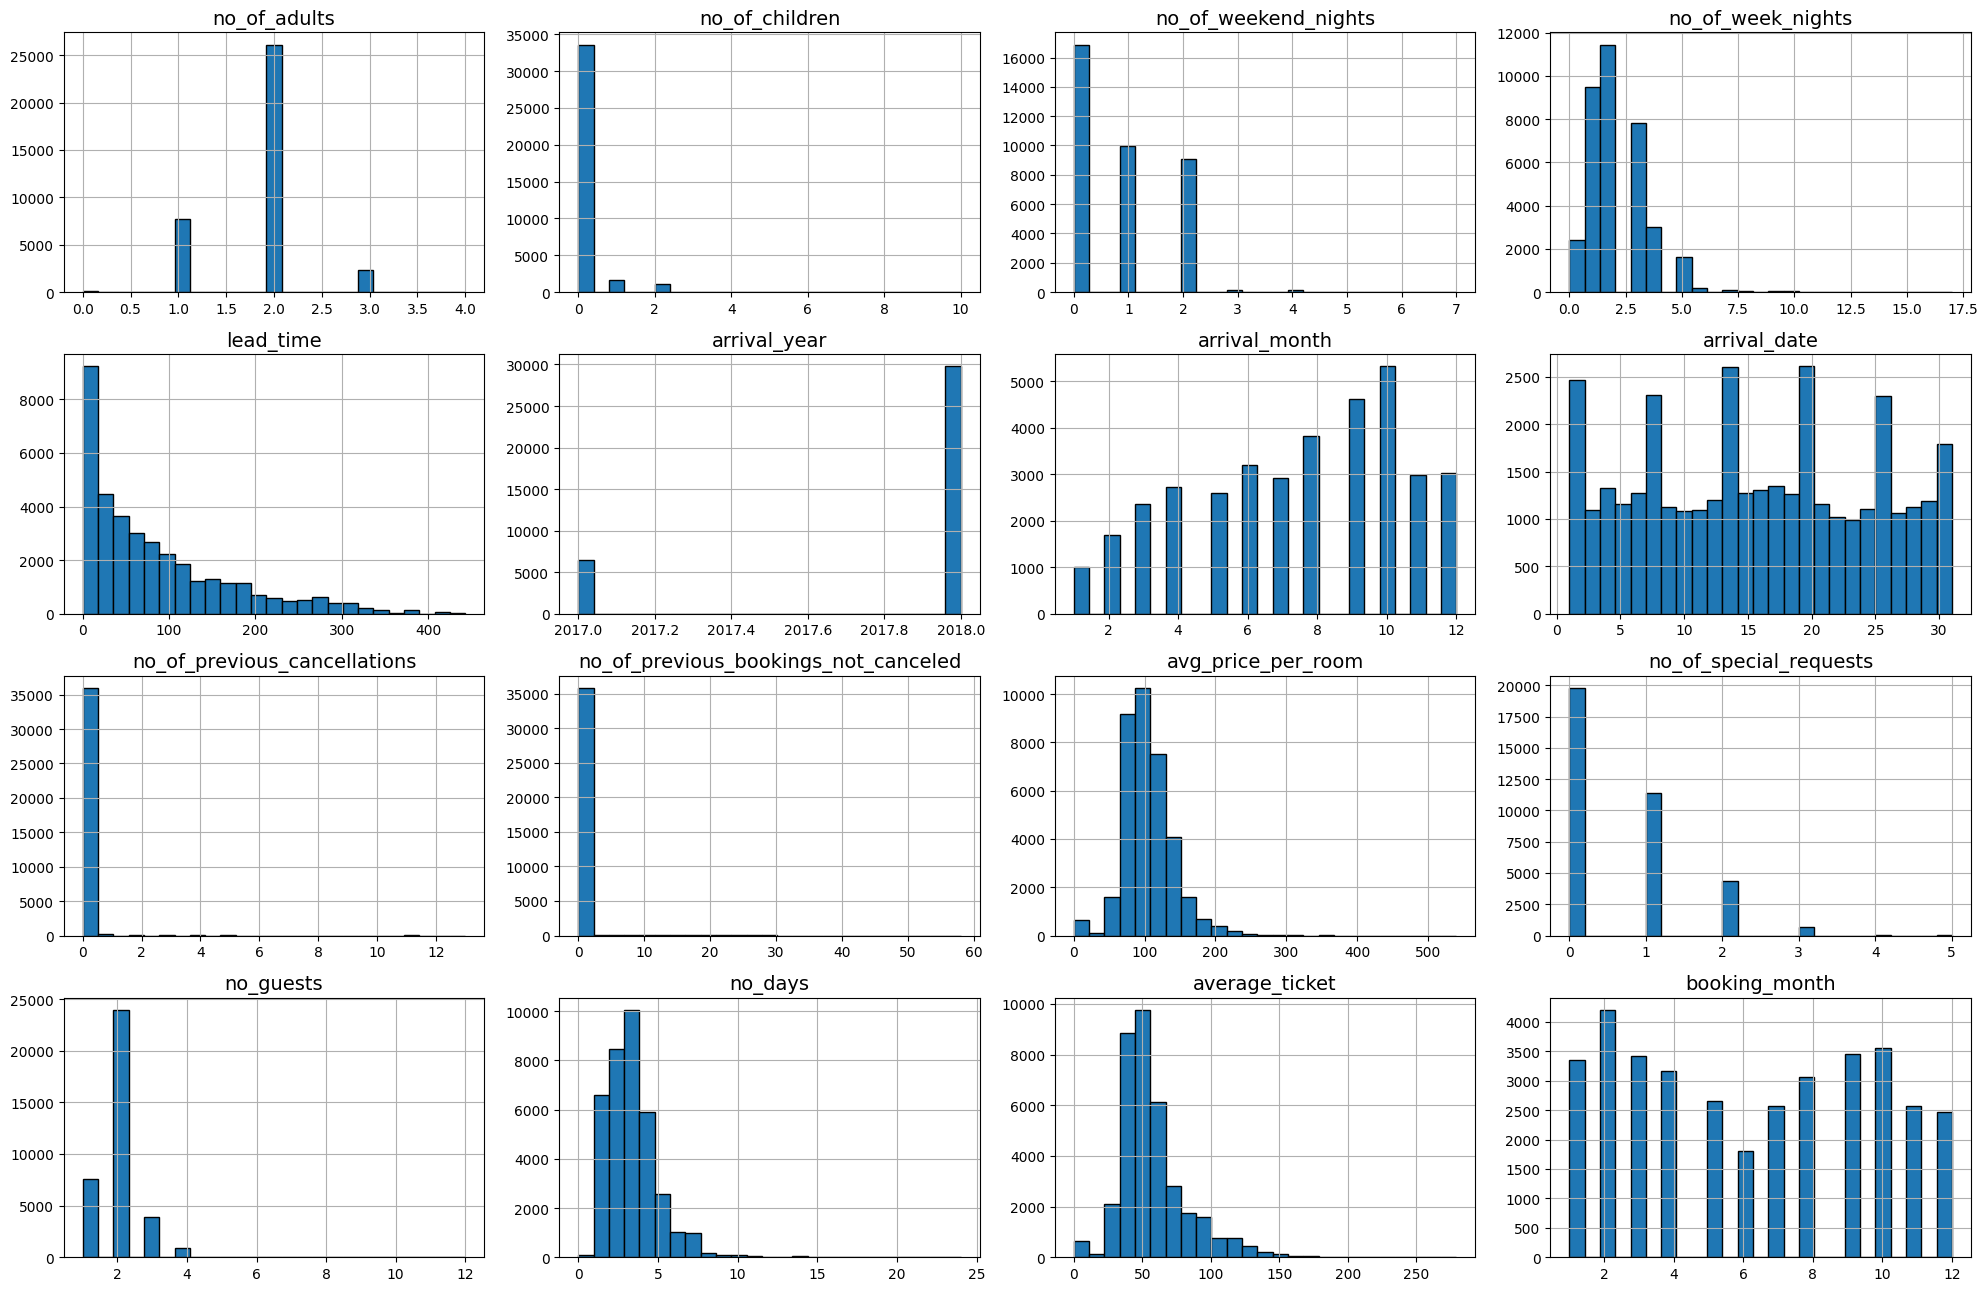

In [14]:
fig = plt.figure(figsize=(20, 16))
ax = fig.subplots(nrows=5, ncols=4)

axes = ax.flatten()

for i, col in enumerate(num_variables.columns):
    num_variables[col].hist(ax=axes[i], bins=25, edgecolor='black')
    axes[i].set_title(col, fontsize=14)
    axes[i].tick_params(axis='both', labelsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Categorical variables

In [15]:
cat_variables = aux.select_dtypes(include=['category','object'])

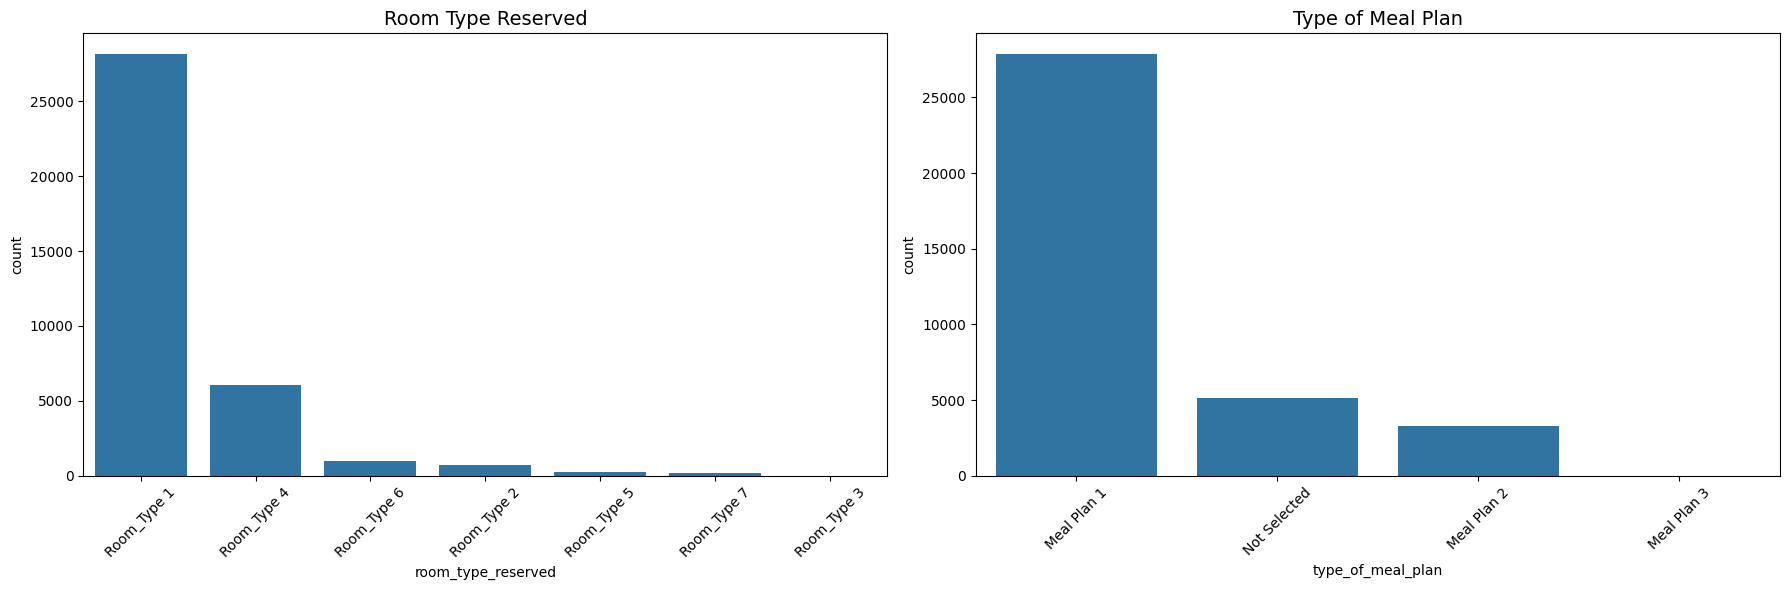

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(data=cat_variables, x='room_type_reserved', ax=axs[0], order=cat_variables['room_type_reserved'].value_counts().index)
axs[0].set_title('Room Type Reserved', fontsize=14)
axs[0].tick_params(axis='x', rotation=45)

sns.countplot(data=cat_variables, x='type_of_meal_plan', ax=axs[1], order=cat_variables['type_of_meal_plan'].value_counts().index)
axs[1].set_title('Type of Meal Plan', fontsize=14)
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Bivariate analysis

## Reservation hypothesis

C:\Users\rafae\AppData\Local\Temp\ipykernel_28204\3677833337.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='booking_status', y='lead_time', palette='Set2')


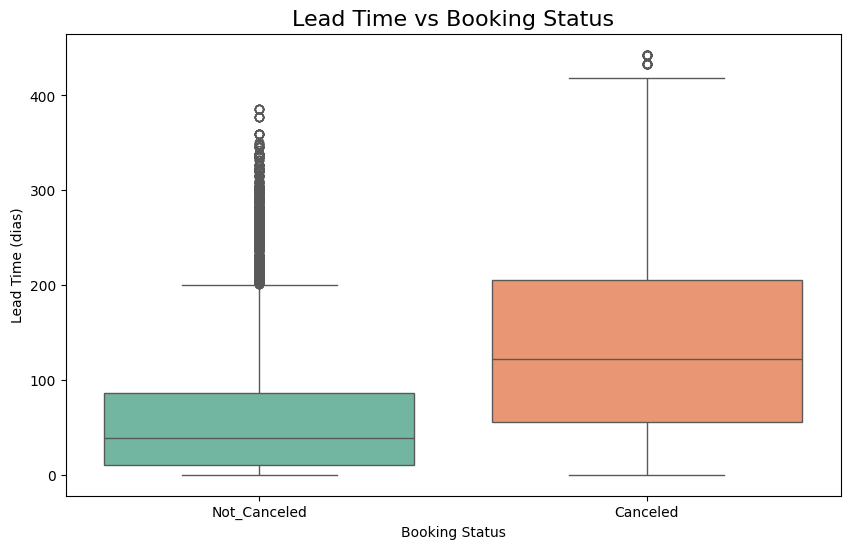

In [17]:
# Greater lead time have a greater chance to cancel

plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='booking_status', y='lead_time', palette='Set2')

plt.title('Lead Time vs Booking Status', fontsize=16)
plt.xlabel('Booking Status')
plt.ylabel('Lead Time (dias)')
plt.show()

C:\Users\rafae\AppData\Local\Temp\ipykernel_28204\1234948850.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='booking_status', y='no_guests', palette='Set2', inner='box')


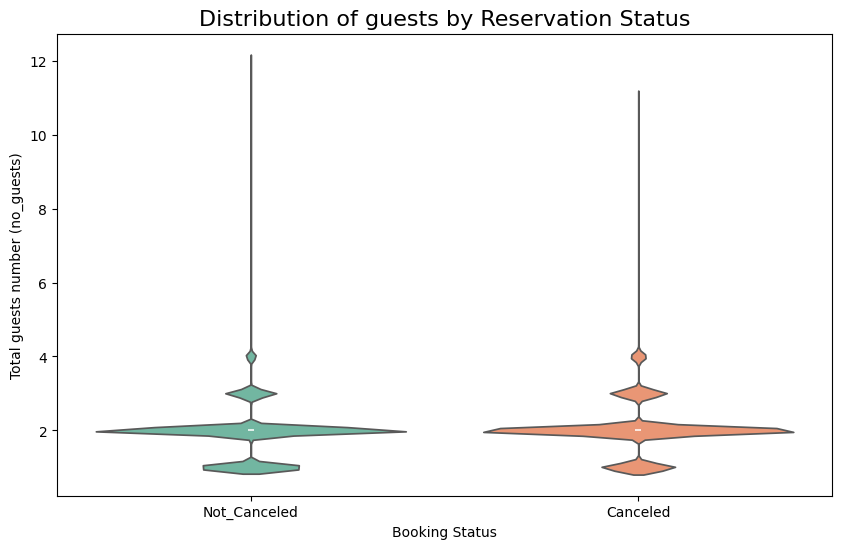

In [18]:
# A higher number of people brings more possibility of cancellation

plt.figure(figsize=(10, 6))

sns.violinplot(data=df, x='booking_status', y='no_guests', palette='Set2', inner='box')

plt.title('Distribution of guests by Reservation Status', fontsize=16)
plt.xlabel('Booking Status')
plt.ylabel('Total guests number (no_guests)')
plt.show()

C:\Users\rafae\AppData\Local\Temp\ipykernel_28204\2404222152.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='booking_status', y='no_of_special_requests', palette='Set2')


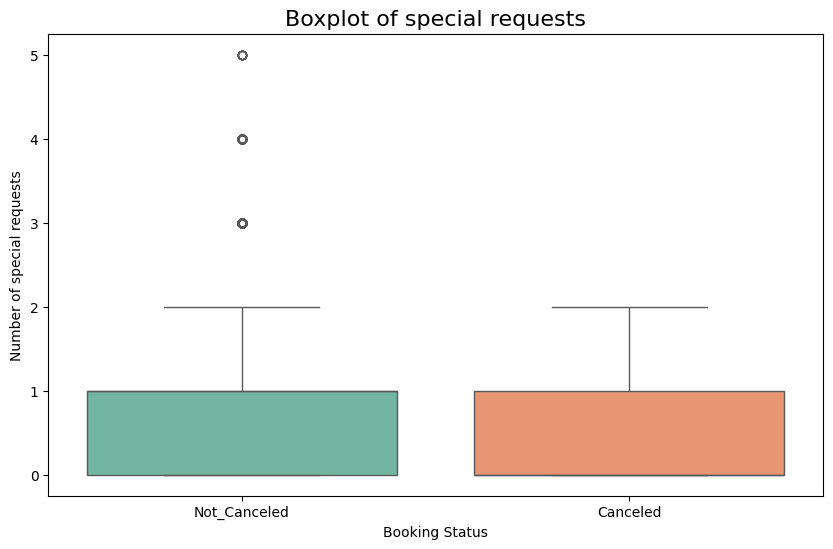

In [19]:
# A high number of special requests indicates greater chance of cancellation

plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='booking_status', y='no_of_special_requests', palette='Set2')

plt.title('Boxplot of special requests', fontsize=16)
plt.xlabel('Booking Status')
plt.ylabel('Number of special requests')
plt.show()

## Client hypothesis

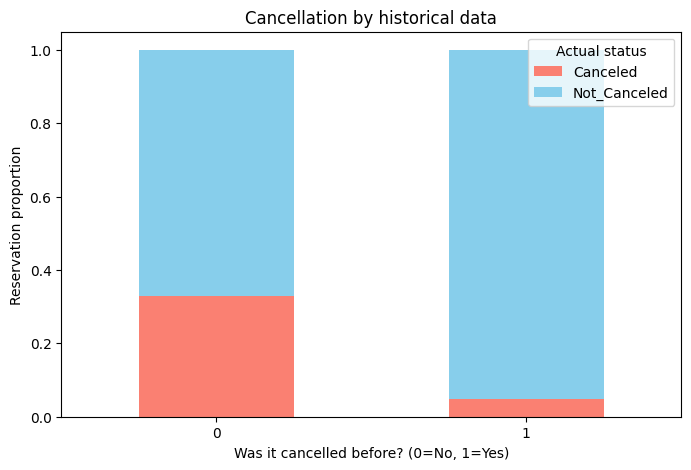

In [20]:
# People that cancelled before may have a greater chance to cancel again

df['has_canceled_before'] = (df['no_of_previous_cancellations'] > 0).astype(int)

cancel_rate = df.groupby('has_canceled_before')['booking_status'].value_counts(normalize=True).unstack()

cancel_rate.plot(kind='bar', stacked=True, figsize=(8, 5), color=['salmon', 'skyblue'])

plt.title('Cancellation by historical data')
plt.xlabel('Was it cancelled before? (0=No, 1=Yes)')
plt.ylabel('Reservation proportion')
plt.legend(title='Actual status', loc='upper right')
plt.xticks(rotation=0)
plt.show()

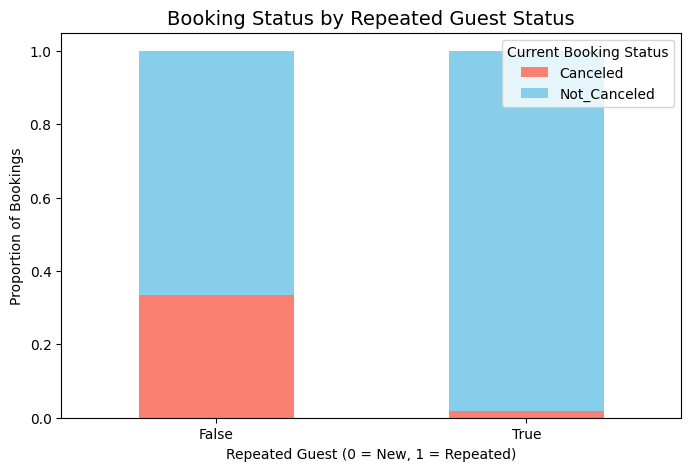

In [21]:
# Old clients tend to cancel less

repeated_rate = df.groupby('repeated_guest')['booking_status'].value_counts(normalize=True).unstack()

# Plot
repeated_rate.plot(kind='bar', stacked=True, figsize=(8, 5), color=['salmon', 'skyblue'])

plt.title('Booking Status by Repeated Guest Status', fontsize=14)
plt.xlabel('Repeated Guest (0 = New, 1 = Repeated)')
plt.ylabel('Proportion of Bookings')
plt.legend(title='Current Booking Status')
plt.xticks(rotation=0)
plt.show()

# Multivariable Analysis

## Numerical Variables

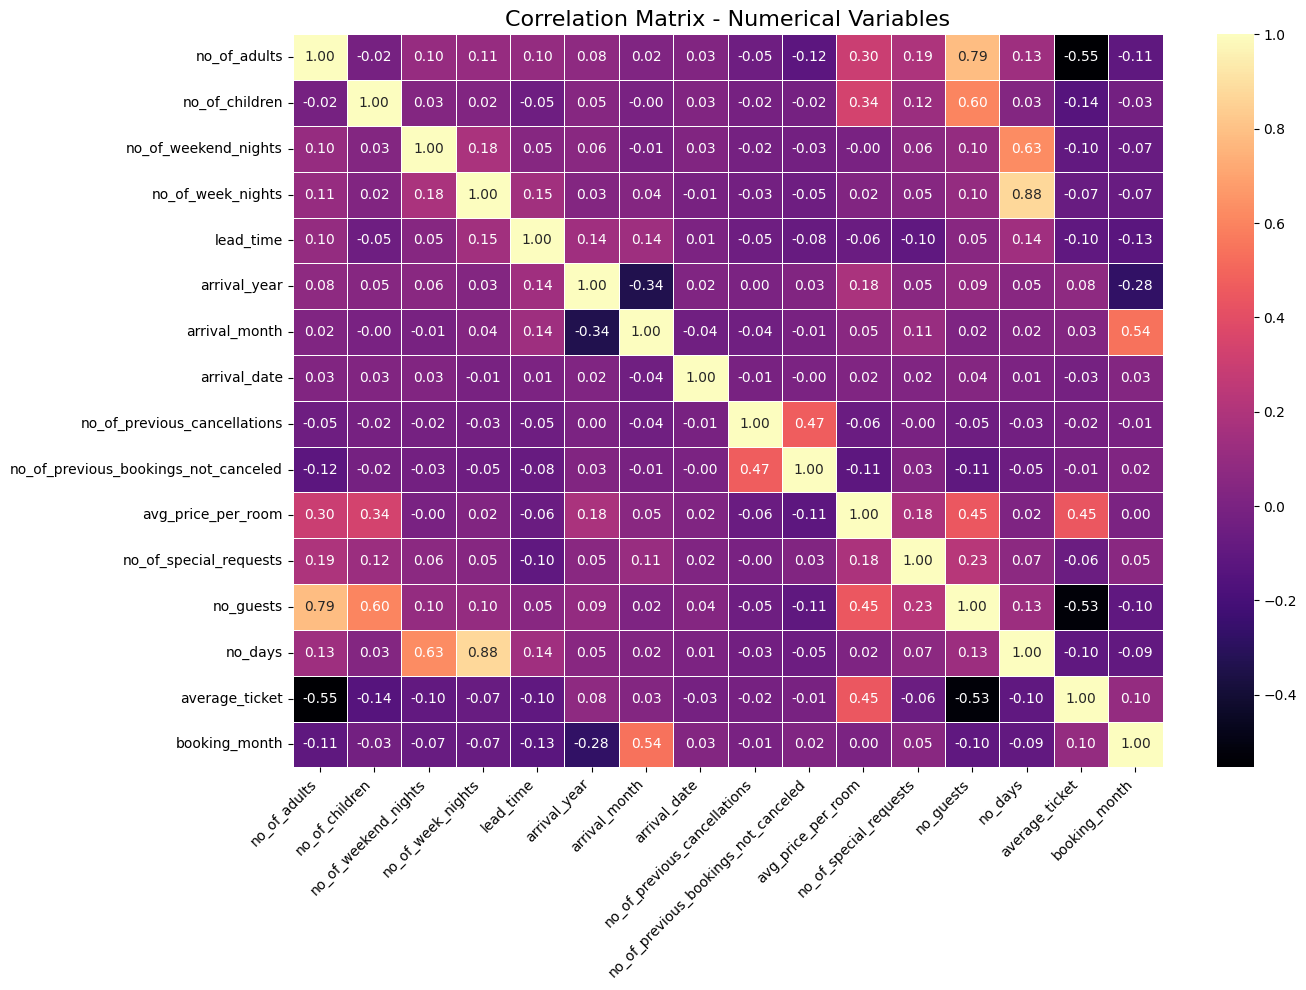

In [22]:
correlation = num_variables.corr(method='pearson')

plt.figure(figsize=(14, 10))

sns.heatmap(correlation, annot=True, cmap='magma', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix - Numerical Variables', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Modeling

## Scaling

In [23]:
df_norm = df.copy()

columns_to_scale = [
    'lead_time',
    'avg_price_per_room',    
    'average_ticket'
]

# Apply scaling
scaler = RobustScaler()
df[columns_to_scale] = scaler.fit_transform(df_norm[columns_to_scale])

df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,avg_price_per_room,no_of_special_requests,booking_status,no_guests,no_days,average_ticket,is_family,booking_month,price_category,has_canceled_before
0,INN00001,2,0,1,2,Meal Plan 1,False,Room_Type 1,1.532110,2017,...,-0.867758,0,Not_Canceled,2,3,-0.801666,False,3,low,0
1,INN00002,2,0,2,3,Not Selected,False,Room_Type 1,-0.477064,2018,...,0.182116,1,Not_Canceled,2,5,0.066216,False,11,mid-high,0
2,INN00003,1,0,2,1,Meal Plan 1,False,Room_Type 1,-0.513761,2018,...,-0.993703,0,Canceled,1,3,0.343571,False,2,low,0
3,INN00004,2,0,0,2,Meal Plan 1,False,Room_Type 1,1.412844,2018,...,0.013854,0,Canceled,2,2,-0.072879,False,10,mid-high,0
4,INN00005,2,0,1,1,Not Selected,False,Room_Type 1,-0.082569,2018,...,-0.124685,0,Canceled,2,2,-0.187402,False,3,mid-low,0


## Encoding

In [ ]:
columns_to_encode = ['room_type_reserved', 'type_of_meal_plan', 'market_segment_type', 'price_category']

df_encoded = df_norm.copy()

label_encoders = {}

for col in columns_to_encode:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  

In [25]:
pd.set_option('display.max_columns', None)
df_encoded.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,no_guests,no_days,average_ticket,is_family,booking_month,price_category,has_canceled_before
0,INN00001,2,0,1,2,0,False,0,224,2017,10,2,3,False,0,0,65.00,0,Not_Canceled,2,3,32.50,False,3,1,0
1,INN00002,2,0,2,3,3,False,0,5,2018,11,6,4,False,0,0,106.68,1,Not_Canceled,2,5,53.34,False,11,2,0
2,INN00003,1,0,2,1,0,False,0,1,2018,2,28,4,False,0,0,60.00,0,Canceled,1,3,60.00,False,2,1,0
3,INN00004,2,0,0,2,0,False,0,211,2018,5,20,4,False,0,0,100.00,0,Canceled,2,2,50.00,False,10,2,0
4,INN00005,2,0,1,1,3,False,0,48,2018,4,11,4,False,0,0,94.50,0,Canceled,2,2,47.25,False,3,3,0


# Attribute Selection

## Feature importance

In [26]:
X = df_encoded.drop(columns=['booking_status','Booking_ID'])
y = df_encoded['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=42)

In [27]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
importances = model.feature_importances_

([<matplotlib.axis.XTick at 0x2aa545c0cd0>,
 [Text(0, 0, 'lead_time'),
  Text(1, 0, 'avg_price_per_room'),
  Text(2, 0, 'no_of_special_requests'),
  Text(3, 0, 'average_ticket'),
  Text(4, 0, 'arrival_date'),
  Text(5, 0, 'arrival_month'),
  Text(6, 0, 'booking_month'),
  Text(7, 0, 'market_segment_type'),
  Text(8, 0, 'no_days'),
  Text(9, 0, 'no_of_week_nights'),
  Text(10, 0, 'no_of_weekend_nights'),
  Text(11, 0, 'arrival_year'),
  Text(12, 0, 'price_category'),
  Text(13, 0, 'type_of_meal_plan'),
  Text(14, 0, 'room_type_reserved'),
  Text(15, 0, 'no_guests'),
  Text(16, 0, 'no_of_adults'),
  Text(17, 0, 'required_car_parking_space'),
  Text(18, 0, 'no_of_children'),
  Text(19, 0, 'is_family'),
  Text(20, 0, 'repeated_guest'),
  Text(21, 0, 'no_of_previous_bookings_not_canceled'),
  Text(22, 0, 'no_of_previous_cancellations'),
  Text(23, 0, 'has_canceled_before')])

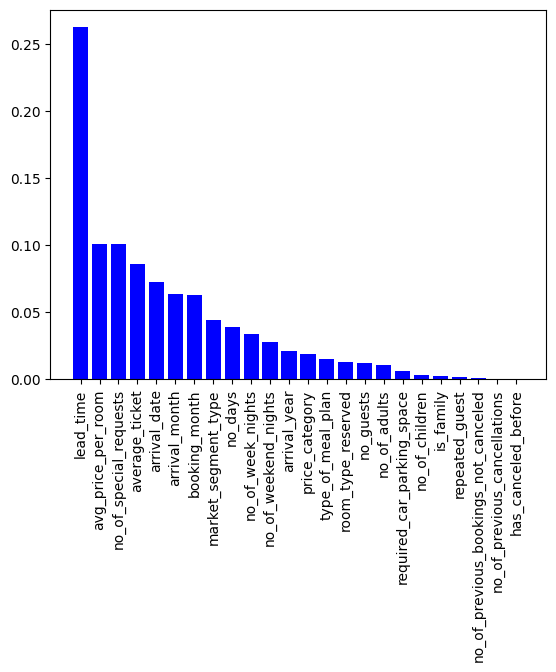

In [28]:
feature_names = X_train.columns
sorted_index = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_index]
sorted_feature_names = feature_names[sorted_index]


plt.bar(range(len(sorted_importances)),sorted_importances, color='b',align='center')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation = 90)

## Elbow Analysis

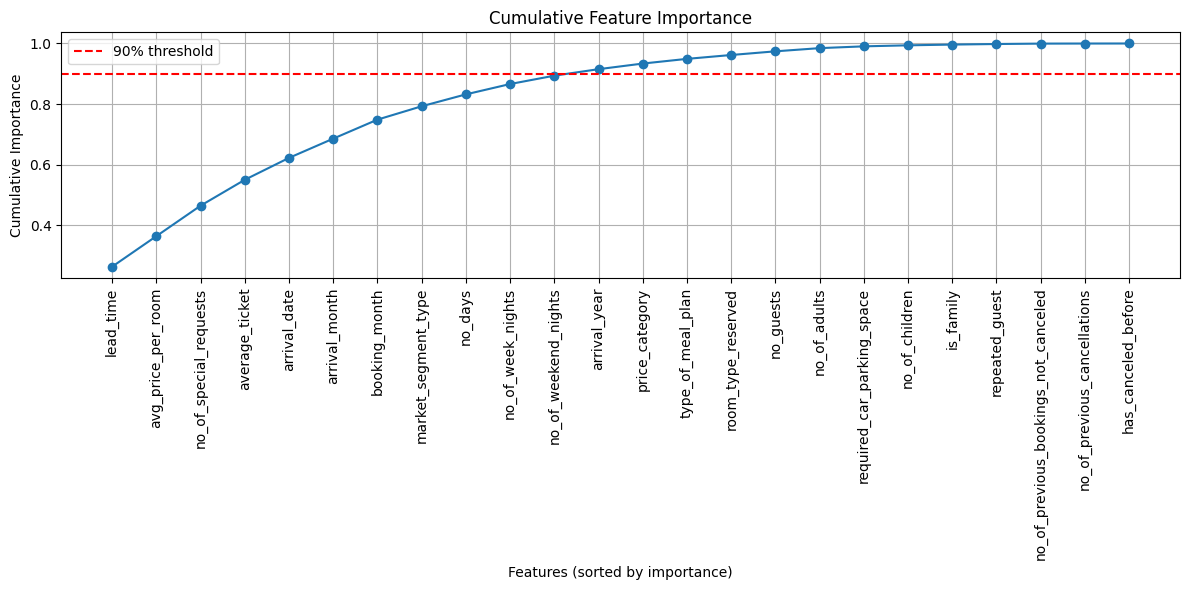

In [29]:
cumulative_importance = np.cumsum(sorted_importances)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_importance)+1), cumulative_importance, marker='o', linestyle='-')
plt.xticks(ticks=range(1, len(sorted_importances)+1), labels=sorted_feature_names, rotation=90)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
plt.title('Cumulative Feature Importance')
plt.xlabel('Features (sorted by importance)')
plt.ylabel('Cumulative Importance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
cumulative_importance = np.cumsum(sorted_importances)

threshold_index = np.argmax(cumulative_importance >= 0.90)

top_features_90 = sorted_feature_names[:threshold_index + 1]

print(f"Number of features explaining 90% of importance: {threshold_index + 1}")
print("Selected features:")
for feature in top_features_90:
    print("-", feature)


Number of features explaining 90% of importance: 12
Selected features:
- lead_time
- avg_price_per_room
- no_of_special_requests
- average_ticket
- arrival_date
- arrival_month
- booking_month
- market_segment_type
- no_days
- no_of_week_nights
- no_of_weekend_nights
- arrival_year


## Boruta

In [31]:
rf = RandomForestClassifier(n_jobs=-1)
boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	16


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	16


In [32]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:,cols_selected].columns.to_list()
cols_selected_boruta


['lead_time',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'avg_price_per_room',
 'no_of_special_requests',
 'average_ticket',
 'booking_month']

# Machine Learning Models

In [33]:
boruta_cols = ['lead_time',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'avg_price_per_room',
 'no_of_special_requests',
 'average_ticket',
 'booking_month']

In [34]:
X = df_encoded[boruta_cols]

le = LabelEncoder()
y = le.fit_transform(df_encoded['booking_status'])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=42, stratify=y)

## Random Forest

In [42]:
rf = RandomForestClassifier()

rf.fit(X_train,y_train)

rf_pred = rf.predict(X_test)

metrics_rf = calculate_metrics('Random Forest', y_test, rf_pred)
metrics_rf

,Algorithm,Precision,Recall,Accuracy
0,Random Forest,0.911998,0.943154,0.900588


## Random Forest Cross Validation


In [43]:
rf_cv = cross_validation_kfold(rf,X, y)

## Decision Tree

In [46]:
dt = DecisionTreeClassifier()

dt.fit(X_train,y_train)

dt_pred = dt.predict(X_test)

metrics_dt = calculate_metrics('Decision Tree', y_test, dt_pred)
metrics_dt

,Algorithm,Precision,Recall,Accuracy
0,Decision Tree,0.898686,0.896966,0.862734


## Decision Tree Cross Validation

In [47]:
dt_cv = cross_validation_kfold(dt,X, y)

## LightGBM Classifier

In [48]:
lg = lgb.LGBMClassifier()

lg.fit(X_train,y_train)

lg_pred = lg.predict(X_test)

metrics_lg = calculate_metrics('LightGBM', y_test, lg_pred)
metrics_lg

[LightGBM] [Info] Number of positive: 20731, number of negative: 10102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 30833, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.672364 -> initscore=0.718897
[LightGBM] [Info] Start training from score 0.718897


,Algorithm,Precision,Recall,Accuracy
0,LightGBM,0.899895,0.938508,0.88846


## LightGBm Classifier Cross Validation

In [49]:
lg_cv = cross_validation_kfold(lg,X, y)

[LightGBM] [Info] Number of positive: 21990, number of negative: 10657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 32647, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.673569 -> initscore=0.724371
[LightGBM] [Info] Start training from score 0.724371
[LightGBM] [Info] Number of positive: 21950, number of negative: 10697
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 32647, number of used features: 8
[LightGBM] [Info] [binar

## XGBoost

In [50]:
xgb = xgb.XGBClassifier()

xgb.fit(X_train,y_train)

xgb_pred = xgb.predict(X_test)

metrics_xgb = calculate_metrics('XGBoost', y_test, xgb_pred)
metrics_xgb

,Algorithm,Precision,Recall,Accuracy
0,XGBoost,0.907179,0.942881,0.896729


## XGBoost Cross Validation

In [51]:
xgb_cv = cross_validation_kfold(xgb,X, y)

## Logistic Regression

In [52]:
lr = LogisticRegression()

lr.fit(X_train,y_train)

lr_pred = lr.predict(X_test)

metrics_lr = calculate_metrics('Logistic Regression', y_test, lr_pred)
metrics_lr

c:\Users\rafae\repos\pos_graduacao\projeto_integrador_1\projeto_integrador1\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Algorithm,Precision,Recall,Accuracy
0,Logistic Regression,0.813777,0.881388,0.784638


## Logistic Regression Cross Validation

In [53]:
lr_cv = cross_validation_kfold(lr,X, y)

c:\Users\rafae\repos\pos_graduacao\projeto_integrador_1\projeto_integrador1\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rafae\repos\pos_graduacao\projeto_integrador_1\projeto_integrador1\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to sca

## All results

In [ ]:
df_metrics = pd.concat([metrics_dt,metrics_lg,metrics_lr,metrics_rf, metrics_xgb])
df_metrics

,Algorithm,Precision,Recall,Accuracy
0,Decision Tree,0.899481,0.899973,0.865123
0,LightGBM,0.898979,0.938781,0.887909
0,Logistic Regression,0.829416,0.896966,0.806689
0,Random Forest,0.910988,0.942607,0.899485
0,XGBoost,0.907179,0.942881,0.896729


## All Results Cross Validation

In [55]:
df_metrics_cv = pd.concat([dt_cv,lg_cv,lr_cv,xgb_cv, rf_cv])
df_metrics_cv


,model,precision,recall
0,DecisionTreeClassifier,0.902163,0.890922
0,LGBMClassifier,0.891566,0.933651
0,LogisticRegression,0.808026,0.883415
0,XGBClassifier,0.899517,0.933974
0,RandomForestClassifier,0.907718,0.936942


# Fine Tunning

## Grid Search

In [59]:
param_grid = {
    'n_estimators': [100, 200, 300],              # number of trees in the forest
    'max_depth': [None, 10, 20, 30],              # max depth of each tree
    'min_samples_split': [2, 5, 10],              # min samples to split an internal node
    'min_samples_leaf': [1, 2, 4],                # min samples at a leaf node
    'max_features': ['sqrt', 'log2', None],       # number of features to consider when looking for the best split
    'bootstrap': [True, False],                   # whether bootstrap samples are used
    'class_weight': [None, 'balanced']            # adjust weights for imbalanced classes
}

In [60]:
grid_search = GridSearchCV(estimator = rf, param_grid=param_grid, cv=5, scoring='precision',n_jobs=1,verbose=2)

grid_search.fit(X_train,y_train)

print('Best Paramaters:')
print(grid_search.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 

## Best Parameters

In [ ]:
# GridSeach Result -> {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

print(grid_search.best_params_)

# Final Model

In [214]:
# GridSeach Result -> {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
# I will not use the best parameters suggested by Gridsearch due to the high demand of memory and the Koyeb limitation
#  
best_params = grid_search.best_params_
best_params_use = {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}

In [212]:
model_tunned = RandomForestClassifier(**best_params_use).fit(X_train,y_train)
y_pred = model_tunned.predict(X_test)

print('Precision in test data:',precision_score(y_test,model_tunned.predict(X_test)))
print('Recall in test data:',recall_score(y_test,model_tunned.predict(X_test)))

# Precision with parameters suggested by gridsearch in test data were: 0.9293069858057333
# Recall with parameters suggested by gridsearch in test data were: 0.9125444110412682

Precision in test data: 0.8912724066999707
Recall in test data: 0.8289150040994807


In [213]:
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [215]:
final_model = RandomForestClassifier(**best_params_use).fit(X_full,y_full)

pickle.dump(final_model,open('final_model.pkl', 'wb'))

# Error and business results

In [94]:
precision = 0.9293

cancel_rate_2018 = 0.36

cancellation_cost = 3500

total_reservations_yearly = 50000

cost_before_model = (cancel_rate_2018 * total_reservations_yearly) * cancellation_cost

forecasted_surprise_cancellation = (1 - precision) * total_reservations_yearly

new_total_cancellation_cost = forecasted_surprise_cancellation * cancellation_cost

total_cost_reduction = cost_before_model - new_total_cancellation_cost

print(
    f"The total cost of cancellations before the model is approximately R$ {cost_before_model:,.2f}. \n"
    f"After this model is working in production, the forecasted total cost with cancellations is R$ {new_total_cancellation_cost:,.2f}. \n"
    f"The total cost reduction is R$ {total_cost_reduction:,.2f} yearly. \n"
    f"This represents a reduction of 80% from the total cancellation cost for HotelSmart")


The total cost of cancellations before the model is approximately R$ 63,000,000.00. 
After this model is working in production, the forecasted total cost with cancellations is R$ 12,372,500.00. 
The total cost reduction is R$ 50,627,500.00 yearly. 
This represents a reduction of 80% from the total cancellation cost for HotelSmart


# Deploy

In [181]:
class PredictCancellation(object):
    def __init__(self):
        self.average_ticket = pickle.load(open('../../parameter/average_ticket_scaler.pkl', 'rb'))                
        self.avg_price_per_room = pickle.load(open('../parameter/avg_price_per_room_scaler.pkl', 'rb'))
        self.lead_time = pickle.load(open('../parameter/lead_time_scaler.pkl', 'rb'))
        self.market_segment_type = pickle.load(open('../parameter/market_segment_type_encoder.pkl', 'rb'))
        self.price_category = pickle.load(open('../parameter/price_category_encoder.pkl', 'rb'))
        self.room_type_reserved = pickle.load(open('../parameter/room_type_reserved_encoder.pkl', 'rb'))
        self.type_of_meal_plan = pickle.load(open('../parameter/type_of_meal_plan_encoder.pkl', 'rb'))

    def convert_binary_columns(self, df):
        binary_cols = ['repeated_guest', 'required_car_parking_space']
        df[binary_cols] = df[binary_cols].astype(bool)
        return df
    
    def feature_engineering(self, df):
        df = df.copy()

        # Criar colunas derivadas
        df['no_guests'] = df['no_of_children'] + df['no_of_adults']
        df['no_days'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
        df['average_ticket'] = df['avg_price_per_room'] / df['no_guests']
        df['is_family'] = ((df['no_of_children'] > 0) & (df['no_of_adults'] >= 2)).astype(bool)

        # Ajustar booking_month
        df['booking_month'] = df['arrival_month'] - (df['lead_time'] // 30)
        df['booking_month'] = df['booking_month'].apply(lambda x: x + 12 if x <= 0 else x)

        # Prevenir erro de qcut com uma linha só ou valores idênticos
        if df['avg_price_per_room'].nunique() < 4:
            df['price_category'] = 'mid-low'  # valor neutro default
        else:
            df['price_category'] = pd.qcut(
                df['avg_price_per_room'],
                q=4,
                labels=['low', 'mid-low', 'mid-high', 'high'],
                duplicates='drop'  # se houver valores repetidos
            )

        return df

    
    def data_preparation(self, df):
        df = df.copy()

        def safe_encode(column, encoder):
            return column.apply(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)

        df['room_type_reserved'] = safe_encode(df['room_type_reserved'], self.room_type_reserved)
        df['type_of_meal_plan'] = safe_encode(df['type_of_meal_plan'], self.type_of_meal_plan)
        df['market_segment_type'] = safe_encode(df['market_segment_type'], self.market_segment_type)
        df['price_category'] = safe_encode(df['price_category'], self.price_category)

        # Escalonamento numérico
        df['lead_time'] = self.lead_time.transform(df[['lead_time']])
        df['avg_price_per_room'] = self.avg_price_per_room.transform(df[['avg_price_per_room']])
        df['average_ticket'] = self.average_ticket.transform(df[['average_ticket']])

        boruta_columns = [
            'lead_time',
            'arrival_month',
            'arrival_date',
            'market_segment_type',
            'avg_price_per_room',
            'no_of_special_requests',
            'average_ticket',
            'booking_month'
        ]

        return df[boruta_columns]

    
    def get_predictions(self, model, test_data,original_data):
        pred= model.predict(test_data)
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records')



## API Handler

In [190]:
model = pickle.load(open('../model/final_model.pkl', 'rb'))


app = Flask(__name__)

@app.route('/HotelSmart/predict', methods=['POST'])
def cancellation_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        pipeline = PredictCancellation()
        df_cleaning = pipeline.convert_binary_columns(test_raw)
        df_feature = pipeline.feature_engineering(df_cleaning)
        df_preparation = pipeline.data_preparation(df_feature)

        df_predict = pipeline.get_predictions(model, df_preparation, test_raw)

        return df_predict, 200
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == "__main__":
    port = os.environ.get('PORT', 5000)
    app.run('0.0.0.0', port=port)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.46:5000
Press CTRL+C to quit


In [203]:
data_test = df.loc[df.index == 20]

In [204]:
data_test

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,no_guests,no_days,average_ticket,is_family,booking_month,price_category,has_canceled_before,prediction
20,INN00021,2,0,2,2,0,False,0,0.385321,2017,10,30,4,False,0,0,-0.867758,0,Canceled,2,4,-0.433879,False,10.0,low,0,1


## Test API

In [205]:
data_test = df.loc[df.index == 20]
#url = 'http://127.0.0.1:5000/HotelSmart/predict'
url = 'https://sheer-sissie-rpimenta1-8d7776bb.koyeb.app/HotelSmart/predict'

header = {'Content-type': 'application/json'}
data = json.dumps(data_test.to_dict(orient='records'))

r = requests.post(url,data=data, headers=header)
print(r.status_code)

524
